# Extract the Bounding Boxes from Person Masks for Supervisely Persons Data

The JSON annotation files for each image in the Supervisely Persons dataset does not contain bounding box information (specifically $x_{min}$, $x_{max}$, $y_{min}$ and $y_{max}$). These are required for the TensorFlow Object Detection API and therefore need to be extracted when creating the TFRecords. This notebook explores how to do this.

## Import Libraries

In [15]:
import sys
import json
import zlib
import base64
import glob
import os
import io

import numpy as np
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import PIL
import PIL.Image

print(f'Python version: {sys.version.split()[0]}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'OpenCV version: {cv.__version__}')
print(f'Pillow version: {PIL.__version__}')

Python version: 3.6.8
Numpy version: 1.16.2
Matplotlib version: 3.0.2
OpenCV version: 4.0.1
Pillow version: 5.4.1


## 1. Open an Annotation File

In [19]:
DATASET_PATH = '/media/adam/HDD Storage/Datasets/supervisely-persons/' # Path to the dataset root
FILE_PATH = 'ds2/ann/pexels-photo-273037.json' # Path from the dataset root to the desired file

In [20]:
with open(DATASET_PATH + FILE_PATH, 'r') as f:
    annotations_dict = json.load(f)

## 2. Convert Serialised Mask to Mask

The following functions are provided by Supervisely ([here](https://docs.supervise.ly/ann_format/)) to convert between serialised masks and masks.

In [21]:
def base64_2_mask(s):
    """
    Convert from a base64 encoded string to numpy mask.
    """
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    
    return mask

def mask_2_base64(mask):
    """
    Convert from a numpy mask to a base64 encoded string.
    """
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

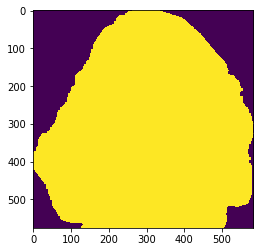

In [22]:
for obj in annotations_dict['objects']:
    img = base64_2_mask(obj['bitmap']['data']).astype(np.uint8)
    plt.imshow(img)
    plt.show()

## 3. Extract Bounding Box Coordinates

We want arrays for each of $x_{min}$, $x_{max}$, $y_{min}$ and $y_{max}$.

In [23]:
x_mins = []
x_maxs = []
y_mins = []
y_maxs = []

# Note: mask/image origins are the top-left corners
img_width = annotations_dict['size']['width']
img_height = annotations_dict['size']['height']

for person in annotations_dict['objects']:
    mask_origin = person['bitmap']['origin']
    mask = base64_2_mask(person['bitmap']['data']).astype(np.uint8)
    mask_height = mask.shape[0]
    mask_width = mask.shape[1]
    
    # Get bounding box coords
    x_min = mask_origin[0]
    x_max = mask_origin[0] + mask_width
    y_min = mask_origin[1]
    y_max = mask_origin[1] + mask_height
    
    x_mins.append(x_min)
    x_maxs.append(x_max)
    y_mins.append(y_min)
    y_maxs.append(y_max)

In [24]:
print(x_mins)
print(x_maxs)
print(y_mins)
print(y_maxs)

[297]
[880]
[223]
[799]


## 4. Creating Whole-Image Masks

For image segmentation, the TensorFlow Object Detection API requires object masks which meet the following requirements:
    
* **Masks must be whole-image masks** (i.e. the dimensions of the masks must match the dimensions of the image).
* **Provide a mask for each object** to be detected in the image.
* Preferably masks should be in **PNG format** (to save space).
* Masks must be **encoded 1 for pixels of the object, 0 otherwise**.

Therefore, since the persons dataset masks are not whole-image masks, we must adapt them.

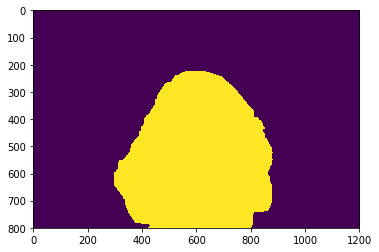

In [25]:
# Note: mask/image origins are the top-left corners
img_width = annotations_dict['size']['width']
img_height = annotations_dict['size']['height']

for person in annotations_dict['objects']:
    mask_origin = person['bitmap']['origin']
    mask = base64_2_mask(person['bitmap']['data']).astype(np.uint8)
    mask_height = mask.shape[0]
    mask_width = mask.shape[1] 
    
    # Create padding
    left_pad = np.zeros((mask_height, mask_origin[0]))
    right_pad = np.zeros((mask_height, img_width - mask_width - mask_origin[0]))
    top_pad = np.zeros((mask_origin[1], img_width))
    bottom_pad = np.zeros((img_height - mask_height - mask_origin[1], img_width))
    
    # Append and prepend padding
    mask = np.hstack((left_pad, mask))
    mask = np.hstack((mask, right_pad))
    mask = np.vstack((top_pad, mask))
    mask = np.vstack((mask, bottom_pad))
    
    plt.imshow(mask)
    plt.show()

In [26]:
img = PIL.Image.fromarray(mask).convert('1')
output = io.BytesIO()
img.save(output, format='PNG')

## 5. Generating `trainval.txt`

In [28]:
examples = []
for dataset_dir in [f.name for f in os.scandir(DATASET_PATH) if f.is_dir()]:
    annotations_path = os.path.join(DATASET_PATH, dataset_dir, 'ann')
    examples += [os.path.join(dataset_dir, 'ann', f.name) for f in os.scandir(annotations_path)]

In [29]:
examples[:10]

['ds1/ann/bodybuilder-weight-training-stress-38630.json',
 'ds1/ann/bow-tie-businessman-fashion-man.json',
 'ds1/ann/bow-tie-fashion-man-person.json',
 'ds1/ann/boy-african-africa-child-47080.json',
 'ds1/ann/brothers-family-siblings-boys-50692.json',
 'ds1/ann/brown-brunette-female-finger-41551.json',
 'ds1/ann/brunette-cute-fashion-female-41366.json',
 'ds1/ann/child-children-girl-happy.json',
 'ds1/ann/city-man-person-lights.json',
 'ds1/ann/city-woman-view-blue-sky.json']